In [ ]:
import geemap

In [ ]:
import ee
import geopandas as gpd
import pandas as pd
import folium
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

ee.Authenticate()
ee.Initialize(project='excavation-482417')

print("✅ Earth Engine initialized")


✅ Earth Engine initialized


In [ ]:
gdf = gpd.read_file("mines_cils.shp")

print("✅ Mines loaded")
print("Number of mines:", len(gdf))
print("Columns:", gdf.columns)


✅ Mines loaded
Number of mines: 506
Columns: Index(['area', 'perimeter', 'geometry'], dtype='object')


In [ ]:
first_mine_geom = ee.Geometry.Polygon(
    gdf.geometry.iloc[0].__geo_interface__['coordinates']
)

mine_id = 0
print("Using mine ID:", mine_id)


Using mine ID: 0


In [ ]:
s2 = (
    ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
    .filterBounds(first_mine_geom)
    .filterDate("2023-01-01", "2023-12-31")
    .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 20))
)

print("Sentinel-2 images over mine:", s2.size().getInfo())


Sentinel-2 images over mine: 72


In [ ]:
def monthly_stats(mine_geom):
    rows = []

    for month in range(1, 13):
        start = ee.Date.fromYMD(2023, month, 1)
        end = start.advance(1, 'month')

        imgs = s2.filterDate(start, end)

        if imgs.size().getInfo() == 0:
            print(f"2023-{month:02d}: no images")
            continue

        def add_indices(img):
            ndvi = img.normalizedDifference(['B8','B4']).rename('NDVI')
            nbr  = img.normalizedDifference(['B8','B12']).rename('NBR')
            swir = img.select('B12').rename('SWIR')
            return img.addBands([ndvi, nbr, swir])

        imgs = imgs.map(add_indices)
        median = imgs.median()

        stats = median.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=mine_geom,
            scale=20
        ).getInfo()

        stats['month'] = month
        rows.append(stats)

        print(f"2023-{month:02d}: processed")

    return pd.DataFrame(rows)


In [ ]:
df = monthly_stats(first_mine_geom)

print("\nMonthly spectral stats:")
print(df[['month','NDVI','NBR','SWIR']])


2023-01: processed
2023-02: processed
2023-03: processed
2023-04: processed
2023-05: processed
2023-06: processed
2023-07: no images
2023-08: processed
2023-09: no images
2023-10: processed
2023-11: processed
2023-12: processed

Monthly spectral stats:
   month      NDVI       NBR         SWIR
0      1  0.385316  0.223096  1581.573797
1      2  0.337504  0.165519  1718.041755
2      3  0.264508  0.085917  1945.206821
3      4  0.239872  0.064383  2193.322557
4      5  0.239229  0.076065  2246.365070
5      6  0.234918  0.083006  2175.819181
6      8  0.374546  0.313331  2160.493636
7     10  0.506523  0.349414  1502.628464
8     11  0.456602  0.304019  1549.837033
9     12  0.432738  0.284436  1418.081789


In [ ]:
BASELINE_MONTHS = [1, 2, 3]  # or any months you trust as reference

baseline = df[df["month"].isin(BASELINE_MONTHS)]

baseline_stats = {
    "NDVI_mean": baseline["NDVI"].mean(),
    "NDVI_std": baseline["NDVI"].std(),
    "NBR_mean": baseline["NBR"].mean(),
    "NBR_std": baseline["NBR"].std(),
}

def detect_anomaly(row, k=1.25):
    ndvi_z = (row["NDVI"] - baseline_stats["NDVI_mean"]) / baseline_stats["NDVI_std"]
    nbr_z = (row["NBR"] - baseline_stats["NBR_mean"]) / baseline_stats["NBR_std"]
    return (ndvi_z < -k) and (nbr_z < -k)

df["excavation_anomaly"] = df.apply(detect_anomaly, axis=1)

print("\nAnomaly-based excavation flags:")
print(df[["month", "NDVI", "NBR", "excavation_anomaly"]])



Anomaly-based excavation flags:
   month      NDVI       NBR  excavation_anomaly
0      1  0.385316  0.223096               False
1      2  0.337504  0.165519               False
2      3  0.264508  0.085917               False
3      4  0.239872  0.064383                True
4      5  0.239229  0.076065               False
5      6  0.234918  0.083006               False
6      8  0.374546  0.313331               False
7     10  0.506523  0.349414               False
8     11  0.456602  0.304019               False
9     12  0.432738  0.284436               False


In [ ]:
# --- KMeans clustering ---
X = df[['NDVI', 'NBR']].values

kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X)

# --- Identify excavated cluster adaptively ---
cluster_stats = df.groupby('cluster')[['NDVI', 'NBR']].mean()
excavated_cluster = cluster_stats.sum(axis=1).idxmin()

# --- Excavation detection ---
df['excavated_raw'] = df['cluster'] == excavated_cluster

# --- Make excavation persistent (CRITICAL FIX) ---
df['excavated'] = df['excavated_raw'].cummax()

# --- Final output ---
df[['month', 'excavated']]


,month,excavated
0,1,False
1,2,True
2,3,True
3,4,True
4,5,True
5,6,True
6,8,True
7,10,True
8,11,True
9,12,True


In [ ]:
def detect_excavation_from_df(df):
    # --- KMeans clustering ---
    X = df[['NDVI', 'NBR']].values

    kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
    df['cluster'] = kmeans.fit_predict(X)

    # --- Identify excavated cluster adaptively ---
    cluster_stats = df.groupby('cluster')[['NDVI', 'NBR']].mean()
    excavated_cluster = cluster_stats.sum(axis=1).idxmin()

    # --- Excavation detection ---
    df['excavated_raw'] = df['cluster'] == excavated_cluster

    # --- Persistent excavation ---
    df['excavated'] = df['excavated_raw'].cummax()

    return df


In [ ]:
def monthly_stats(mine_geom, s2):
    rows = []
    months_with_data = []

    for month in range(1, 13):
        start = ee.Date.fromYMD(2023, month, 1)
        end = start.advance(1, 'month')

        imgs = s2.filterDate(start, end)

        if imgs.size().getInfo() == 0:
            print(f"2023-{month:02d} no images")
            continue

        months_with_data.append(month)

        def add_indices(img):
            ndvi = img.normalizedDifference(['B8', 'B4']).rename('NDVI')
            nbr = img.normalizedDifference(['B8', 'B12']).rename('NBR')
            swir = img.select('B12').rename('SWIR')
            return img.addBands([ndvi, nbr, swir])

        imgs = imgs.map(add_indices)
        median = imgs.median()

        stats = median.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=mine_geom,
            scale=20,
            maxPixels=1e9
        ).getInfo()

        stats['month'] = month
        rows.append(stats)

        print(f"2023-{month:02d} processed")

    if not rows:
        return None, []

    return pd.DataFrame(rows), months_with_data


In [ ]:
s2 = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
      .filterBounds(mine_geom)
      .filterDate('2023-01-01', '2023-12-31')
      .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)))

df, months_with_data = monthly_stats(mine_geom, s2)


2023-01 processed
2023-02 processed
2023-03 processed
2023-04 processed
2023-05 processed
2023-06 processed
2023-07 no images
2023-08 processed
2023-09 no images
2023-10 processed
2023-11 processed
2023-12 processed


In [ ]:
def row_to_ee_polygon(geom):
    return ee.Geometry.Polygon(geom.__geo_interface__['coordinates'])

def monthly_stats(mine_geom):
    rows = []
    for month in range(1, 13):
        start = ee.Date.fromYMD(2023, month, 1)
        end = start.advance(1, 'month')
        imgs = s2.filterDate(start, end)
        if imgs.size().getInfo() == 0:
            print(f"2023-{month:02d} no images")
            continue

        def add_indices(img):
            ndvi = img.normalizedDifference(['B8', 'B4']).rename('NDVI')
            nbr = img.normalizedDifference(['B8', 'B12']).rename('NBR')
            swir = img.select('B12').rename('SWIR')
            return img.addBands([ndvi, nbr, swir])

        imgs = imgs.map(add_indices)
        median = imgs.median()

        stats = median.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=mine_geom,
            scale=20
        ).getInfo()
        stats['month'] = month
        rows.append(stats)
        print(f"2023-{month:02d} processed")

    return pd.DataFrame(rows)


In [ ]:
results = []

for idx, row in gdf.head(5).iterrows():
    print(f"\n=== Mine {idx} ===")
    mine_geom = row_to_ee_polygon(row.geometry)

    s2 = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
          .filterBounds(mine_geom)
          .filterDate('2023-01-01', '2023-12-31')
          .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)))

    if s2.size().getInfo() == 0:
        print("No Sentinel-2 images for this mine")
        continue

    df = monthly_stats(mine_geom)
    df['mine_id'] = idx
    results.append(df)

# Combine all 5 mines
all_df = pd.concat(results, ignore_index=True)



=== Mine 0 ===
2023-01 processed
2023-02 processed
2023-03 processed
2023-04 processed
2023-05 processed
2023-06 processed
2023-07 no images
2023-08 processed
2023-09 no images
2023-10 processed
2023-11 processed
2023-12 processed

=== Mine 1 ===
2023-01 processed
2023-02 processed
2023-03 processed
2023-04 processed
2023-05 processed
2023-06 processed
2023-07 no images
2023-08 processed
2023-09 no images
2023-10 processed
2023-11 processed
2023-12 processed

=== Mine 2 ===
2023-01 processed
2023-02 processed
2023-03 processed
2023-04 processed
2023-05 processed
2023-06 processed
2023-07 no images
2023-08 processed
2023-09 processed
2023-10 processed
2023-11 processed
2023-12 processed

=== Mine 3 ===
2023-01 processed
2023-02 processed
2023-03 processed
2023-04 processed
2023-05 processed
2023-06 processed
2023-07 no images
2023-08 no images
2023-09 no images
2023-10 processed
2023-11 processed
2023-12 processed

=== Mine 4 ===
2023-01 processed
2023-02 processed
2023-03 processed
20

In [ ]:
print(all_df.columns)
print(all_df.head())


Index(['AOT', 'B1', 'B11', 'B12', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8',
       'B8A', 'B9', 'MSK_CLASSI_CIRRUS', 'MSK_CLASSI_OPAQUE',
       'MSK_CLASSI_SNOW_ICE', 'MSK_CLDPRB', 'MSK_SNWPRB', 'NBR', 'NDVI',
       'QA10', 'QA20', 'QA60', 'SCL', 'SWIR', 'TCI_B', 'TCI_G', 'TCI_R', 'WVP',
       'month', 'mine_id'],
      dtype='object')
          AOT          B1          B11          B12          B2           B3  \
0  196.957690  406.706423  2388.050135  1581.573797  496.984645   762.267954   
1  136.804612  474.584406  2535.835914  1718.041755  564.796602   823.876216   
2  360.949504  637.625754  2818.292652  1945.206821  684.584443   942.089124   
3  245.030174  573.491416  3099.168128  2193.322557  658.212648  1010.512645   
4  433.537093  633.790904  3181.534678  2246.365070  765.686989  1126.480149   

            B4           B5           B6           B7  ...  QA20  QA60  \
0  1151.622174  1544.047138  2155.995967  2337.958079  ...   0.0     0   
1  1250.157546  1623.576766  2

In [ ]:
print("\n=== SUMMARY FOR FIRST 5 MINES (RAW STATS ONLY) ===")
print(f"Total records: {len(all_df)}")
print(f"Mines processed: {sorted(all_df['mine_id'].unique().tolist())}")

# Just show min/max month and mean NDVI per mine
for mine_id, grp in all_df.groupby('mine_id'):
    months = sorted(grp['month'].astype(int).unique().tolist())
    mean_ndvi = grp['NDVI'].mean()
    print(f"  Mine {mine_id}: months {months}, mean NDVI ≈ {mean_ndvi:.3f}")

print("\nSample rows (first 10):")
cols = [c for c in ['mine_id', 'month', 'NDVI', 'NBR', 'SWIR'] if c in all_df.columns]
print(all_df[cols].head(10))



=== SUMMARY FOR FIRST 5 MINES (RAW STATS ONLY) ===
Total records: 50
Mines processed: [0, 1, 2, 3, 4]
  Mine 0: months [1, 2, 3, 4, 5, 6, 8, 10, 11, 12], mean NDVI ≈ 0.347
  Mine 1: months [1, 2, 3, 4, 5, 6, 8, 10, 11, 12], mean NDVI ≈ 0.235
  Mine 2: months [1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12], mean NDVI ≈ 0.355
  Mine 3: months [1, 2, 3, 4, 5, 6, 10, 11, 12], mean NDVI ≈ 0.290
  Mine 4: months [1, 2, 3, 4, 5, 6, 8, 10, 11, 12], mean NDVI ≈ 0.329

Sample rows (first 10):
   mine_id  month      NDVI       NBR         SWIR
0        0      1  0.385316  0.223096  1581.573797
1        0      2  0.337504  0.165519  1718.041755
2        0      3  0.264508  0.085917  1945.206821
3        0      4  0.239872  0.064383  2193.322557
4        0      5  0.239229  0.076065  2246.365070
5        0      6  0.234918  0.083006  2175.819181
6        0      8  0.374546  0.313331  2160.493636
7        0     10  0.506523  0.349414  1502.628464
8        0     11  0.456602  0.304019  1549.837033
9        0  

In [ ]:
from sklearn.cluster import KMeans
import numpy as np

df_list = []

for mine_id, grp in all_df.groupby('mine_id'):
    # Work per mine, sorted by month
    dfm = grp.sort_values('month').reset_index(drop=True).copy()

    # KMeans on NDVI + NBR
    X = dfm[['NDVI', 'NBR']].values
    kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
    dfm['cluster'] = kmeans.fit_predict(X)

    # Cluster with lower NDVI+NBR = excavated
    cluster_stats = dfm.groupby('cluster')[['NDVI', 'NBR']].mean()
    excavated_cluster = cluster_stats.sum(axis=1).idxmin()

    # Excavation flags
    dfm['excavated_raw'] = dfm['cluster'] == excavated_cluster
    dfm['excavated'] = dfm['excavated_raw'].cummax()   # persistent excavation

    df_list.append(dfm)

# Replace all_df with version that has excavation flags
all_df = pd.concat(df_list, ignore_index=True)

print(all_df[['mine_id', 'month', 'NDVI', 'NBR', 'excavated']].head(15))


    mine_id  month      NDVI       NBR  excavated
0         0      1  0.385316  0.223096      False
1         0      2  0.337504  0.165519       True
2         0      3  0.264508  0.085917       True
3         0      4  0.239872  0.064383       True
4         0      5  0.239229  0.076065       True
5         0      6  0.234918  0.083006       True
6         0      8  0.374546  0.313331       True
7         0     10  0.506523  0.349414       True
8         0     11  0.456602  0.304019       True
9         0     12  0.432738  0.284436       True
10        1      1  0.196947  0.070930       True
11        1      2  0.160746 -0.019474       True
12        1      3  0.136198 -0.054654       True
13        1      4  0.117008 -0.075452       True
14        1      5  0.194077  0.001726       True


In [ ]:
print("\n=== EXCAVATION SUMMARY (FIRST 5 MINES) ===")
for mine_id, grp in all_df.groupby('mine_id'):
    excav = grp[grp['excavated']]
    if excav.empty:
        print(f"  Mine {mine_id}: no persistent excavation detected")
        continue
    first_m = int(excav['month'].min())
    last_m  = int(excav['month'].max())
    print(f"  Mine {mine_id}: excavation from month {first_m} to {last_m}")



=== EXCAVATION SUMMARY (FIRST 5 MINES) ===
  Mine 0: excavation from month 2 to 12
  Mine 1: excavation from month 1 to 12
  Mine 2: excavation from month 3 to 12
  Mine 3: excavation from month 1 to 12
  Mine 4: excavation from month 1 to 12


In [ ]:
df_change = df.copy()

df_change['dNDVI'] = df_change['NDVI'].diff()
df_change['dNBR']  = df_change['NBR'].diff()
df_change['dSWIR'] = df_change['SWIR'].diff()

# First month has NaNs → drop it
df_change = df_change.dropna().reset_index(drop=True)


In [ ]:
X = df_change[['dNDVI','dNBR','dSWIR']].values

X_scaled = StandardScaler().fit_transform(X)

kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
df_change['cluster'] = kmeans.fit_predict(X_scaled)


In [ ]:
cluster_means = df_change.groupby('cluster')[['dNDVI','dNBR','dSWIR']].mean()
print("\nCluster behavior:")
print(cluster_means)

# Excavation cluster = strongest SWIR increase
excav_cluster = cluster_means['dSWIR'].idxmax()

df_change['excavated'] = df_change['cluster'] == excav_cluster



Cluster behavior:
            dNDVI      dNBR       dSWIR
cluster                                
0       -0.047812 -0.057577  136.467958
1       -0.072997 -0.079602  227.165066


In [ ]:
df[['month', 'excavated']]


,month,excavated
0,1,False
1,2,True
2,3,True
3,4,True
4,5,True
5,6,True
6,8,True
7,10,True
8,11,True
9,12,True


In [ ]:
center = first_mine_geom.centroid().coordinates().getInfo()

m = folium.Map(location=[center[1], center[0]], zoom_start=12)

folium.GeoJson(
    ee.FeatureCollection([first_mine_geom]).getInfo(),
    style_function=lambda x: {
        'color': 'red',
        'weight': 3,
        'fillOpacity': 0.2
    }
).add_to(m)

m


In [ ]:
# Months where excavation happened
excavated_months = df[df['excavated'] == True]['month'].tolist()

print("Excavation detected in months:", excavated_months)


Excavation detected in months: [2, 3, 4, 5, 6, 8, 10, 11, 12]


In [ ]:
# -------------------------------------------
# SIMPLE STATISTICAL CHANGE / ANOMALY DETECTION
# -------------------------------------------

# Assume df already has columns: 'month', 'NDVI', 'NBR', 'SWIR'
# You can tune this: how many initial months are considered "baseline"
BASELINE_MONTHS = [1, 2, 3]  # Jan–Mar as reference, change as needed

baseline = df[df["month"].isin(BASELINE_MONTHS)]

# Compute baseline mean and std for each index
baseline_stats = {
    "NDVI_mean": baseline["NDVI"].mean(),
    "NDVI_std": baseline["NDVI"].std(),
    "NBR_mean": baseline["NBR"].mean(),
    "NBR_std": baseline["NBR"].std(),
}

def detect_anomaly(row, k=1.25):
    """
    Returns True if NDVI/NBR for that month is significantly lower
    than the baseline by more than k standard deviations.
    """
    ndvi_z = (row["NDVI"] - baseline_stats["NDVI_mean"]) / baseline_stats["NDVI_std"]
    nbr_z = (row["NBR"] - baseline_stats["NBR_mean"]) / baseline_stats["NBR_std"]

    # Excavation-like anomaly → NDVI and NBR both drop
    return (ndvi_z < -k) and (nbr_z < -k)

df["excavation_anomaly"] = df.apply(detect_anomaly, axis=1)

print("Anomaly-based excavation flags:")
print(df[["month", "NDVI", "NBR", "excavation_anomaly"]])



Anomaly-based excavation flags:
   month      NDVI       NBR  excavation_anomaly
0      1  0.385316  0.223096               False
1      2  0.337504  0.165519               False
2      3  0.264508  0.085917               False
3      4  0.239872  0.064383                True
4      5  0.239229  0.076065               False
5      6  0.234918  0.083006               False
6      8  0.374546  0.313331               False
7     10  0.506523  0.349414               False
8     11  0.456602  0.304019               False
9     12  0.432738  0.284436               False


In [ ]:
# Combine KMeans-based excavation and anomaly-based excavation
df["excavated_combined"] = df["excavated"] | df["excavation_anomaly"]

print("Combined excavation flags:")
print(df[["month", "excavated", "excavation_anomaly", "excavated_combined"]])

# For quick check: which months are combined-excavated?
combined_months = df[df["excavated_combined"] == True]["month"].tolist()
print("Excavation (combined) detected in months:", combined_months)


Combined excavation flags:
   month  excavated  excavation_anomaly  excavated_combined
0      1      False               False               False
1      2       True               False                True
2      3       True               False                True
3      4       True                True                True
4      5       True               False                True
5      6       True               False                True
6      8       True               False                True
7     10       True               False                True
8     11       True               False                True
9     12       True               False                True
Excavation (combined) detected in months: [2, 3, 4, 5, 6, 8, 10, 11, 12]


In [ ]:
# Work on the 5‑mine all_df with 'excavated' flag
area_profiles = []

for mine_id, grp in all_df.groupby('mine_id'):
    grp = grp.sort_values('month')

    # Treat 'excavated' as 0/1 and smooth a bit to reduce noise
    grp['excav_flag'] = grp['excavated'].astype(int)
    grp['excav_area_index'] = grp['excav_flag'].rolling(window=2, min_periods=1).mean()

    # Make it progressive (never decreases) to suppress seasonal artifacts
    grp['excav_area_progressive'] = grp['excav_area_index'].cummax()

    area_profiles.append(grp)

area_df = pd.concat(area_profiles, ignore_index=True)

print(area_df[['mine_id','month','excavated','excav_area_progressive']].head(20))


    mine_id  month  excavated  excav_area_progressive
0         0      1      False                     0.0
1         0      2       True                     0.5
2         0      3       True                     1.0
3         0      4       True                     1.0
4         0      5       True                     1.0
5         0      6       True                     1.0
6         0      8       True                     1.0
7         0     10       True                     1.0
8         0     11       True                     1.0
9         0     12       True                     1.0
10        1      1       True                     1.0
11        1      2       True                     1.0
12        1      3       True                     1.0
13        1      4       True                     1.0
14        1      5       True                     1.0
15        1      6       True                     1.0
16        1      8       True                     1.0
17        1     10       Tru

In [ ]:
rate_profiles = []

for mine_id, grp in area_df.groupby('mine_id'):
    grp = grp.sort_values('month').copy()
    grp['excav_rate'] = grp['excav_area_progressive'].diff().fillna(0)
    rate_profiles.append(grp)

area_df = pd.concat(rate_profiles, ignore_index=True)

print(area_df[['mine_id','month','excav_area_progressive','excav_rate']].head(20))


    mine_id  month  excav_area_progressive  excav_rate
0         0      1                     0.0         0.0
1         0      2                     0.5         0.5
2         0      3                     1.0         0.5
3         0      4                     1.0         0.0
4         0      5                     1.0         0.0
5         0      6                     1.0         0.0
6         0      8                     1.0         0.0
7         0     10                     1.0         0.0
8         0     11                     1.0         0.0
9         0     12                     1.0         0.0
10        1      1                     1.0         0.0
11        1      2                     1.0         0.0
12        1      3                     1.0         0.0
13        1      4                     1.0         0.0
14        1      5                     1.0         0.0
15        1      6                     1.0         0.0
16        1      8                     1.0         0.0
17        

In [ ]:
def monthly_excavation_mask(mine_geom, year=2023):
    monthly_masks = []

    for month in range(1, 13):
        start = ee.Date.fromYMD(year, month, 1)
        end = start.advance(1, 'month')

        imgs = (
            s2
            .filterBounds(mine_geom)
            .filterDate(start, end)
        )

        def add_indices(img):
            ndvi = img.normalizedDifference(['B8','B4']).rename('NDVI')
            nbr  = img.normalizedDifference(['B8','B12']).rename('NBR')
            swir = img.select('B12').rename('SWIR')
            return img.addBands([ndvi, nbr, swir])

        composite = imgs.map(add_indices).median().clip(mine_geom)

        # Stack indices
        stack = composite.select(['NDVI','NBR','SWIR'])

        # KMeans on pixels
        training = stack.sample(
            region=mine_geom,
            scale=20,
            numPixels=5000,
            seed=42
        )

        clusterer = ee.Clusterer.wekaKMeans(2).train(training)
        clusters = stack.cluster(clusterer)

        # Identify excavated cluster
        stats = stack.addBands(clusters).reduceRegion(
            reducer=ee.Reducer.mean().group(1),
            geometry=mine_geom,
            scale=20
        )

        groups = ee.List(stats.get('groups'))

        def get_cluster_mean(g):
            g = ee.Dictionary(g)
            return ee.Number(g.get('mean_NDVI')).add(
                   ee.Number(g.get('mean_NBR')))

        scores = groups.map(get_cluster_mean)
        excav_cluster = scores.indexOf(scores.reduce(ee.Reducer.min()))

        excav_mask = clusters.eq(excav_cluster).rename(f'excav_{month}')

        monthly_masks.append(excav_mask)

    return monthly_masks


In [ ]:
def cumulative_excavation(masks):
    cumulative = masks[0]
    for m in masks[1:]:
        cumulative = cumulative.Or(m)
    return cumulative


In [ ]:
def excavation_area_time_series(masks, mine_geom):
    pixel_area = ee.Image.pixelArea()
    rows = []

    cumulative = masks[0]

    for i, mask in enumerate(masks):
        cumulative = cumulative.Or(mask)

        area = (
            cumulative
            .multiply(pixel_area)
            .reduceRegion(
                reducer=ee.Reducer.sum(),
                geometry=mine_geom,
                scale=20,
                maxPixels=1e9
            )
            .getInfo()
        )

        rows.append({
            "month": i + 1,
            "excavated_area_m2": area[list(area.keys())[0]]
        })

    return pd.DataFrame(rows)


In [ ]:
print(area_df.columns)


Index(['AOT', 'B1', 'B11', 'B12', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8',
       'B8A', 'B9', 'MSK_CLASSI_CIRRUS', 'MSK_CLASSI_OPAQUE',
       'MSK_CLASSI_SNOW_ICE', 'MSK_CLDPRB', 'MSK_SNWPRB', 'NBR', 'NDVI',
       'QA10', 'QA20', 'QA60', 'SCL', 'SWIR', 'TCI_B', 'TCI_G', 'TCI_R', 'WVP',
       'month', 'mine_id', 'cluster', 'excavated_raw', 'excavated',
       'excav_flag', 'excav_area_index', 'excav_area_progressive',
       'excav_rate'],
      dtype='object')


In [ ]:
# ================================
# Excavated Area Temporal Profiling
# ================================

# Use the correct dataframe
df = area_df.copy()

# Ensure correct time order
df = df.sort_values("month").reset_index(drop=True)

# ------------------------------------------------------------------
# Enforce progressive excavation (prevents seasonal rollback)
# ------------------------------------------------------------------
df["excav_area_progressive"] = (
    df["excav_area_progressive"]
    .cummax()
)

# ------------------------------------------------------------------
# Excavation rate = month-to-month increase in excavated area
# (negative values clipped to remove illumination / seasonal effects)
# ------------------------------------------------------------------
df["excav_rate"] = (
    df["excav_area_progressive"]
    .diff()
    .clip(lower=0)
    .fillna(0)
)

# ------------------------------------------------------------------
# Smooth excavation rate for clean temporal trend
# ------------------------------------------------------------------
df["excav_rate_smooth"] = (
    df["excav_rate"]
    .rolling(window=3, min_periods=1)
    .mean()
)

# ------------------------------------------------------------------
# Final output (ready for plotting / reporting)
# ------------------------------------------------------------------
final_df = df[
    [
        "month",
        "mine_id",
        "excav_area_progressive",
        "excav_rate",
        "excav_rate_smooth"
    ]
]

print("✅ Excavation Temporal Profile")
print(final_df)


✅ Excavation Temporal Profile
    month  mine_id  excav_area_progressive  excav_rate  excav_rate_smooth
0       1        0                     0.0         0.0           0.000000
1       1        1                     1.0         1.0           0.500000
2       1        3                     1.0         0.0           0.333333
3       1        2                     1.0         0.0           0.333333
4       1        4                     1.0         0.0           0.000000
5       2        1                     1.0         0.0           0.000000
6       2        0                     1.0         0.0           0.000000
7       2        2                     1.0         0.0           0.000000
8       2        3                     1.0         0.0           0.000000
9       2        4                     1.0         0.0           0.000000
10      3        2                     1.0         0.0           0.000000
11      3        4                     1.0         0.0           0.000000
12      

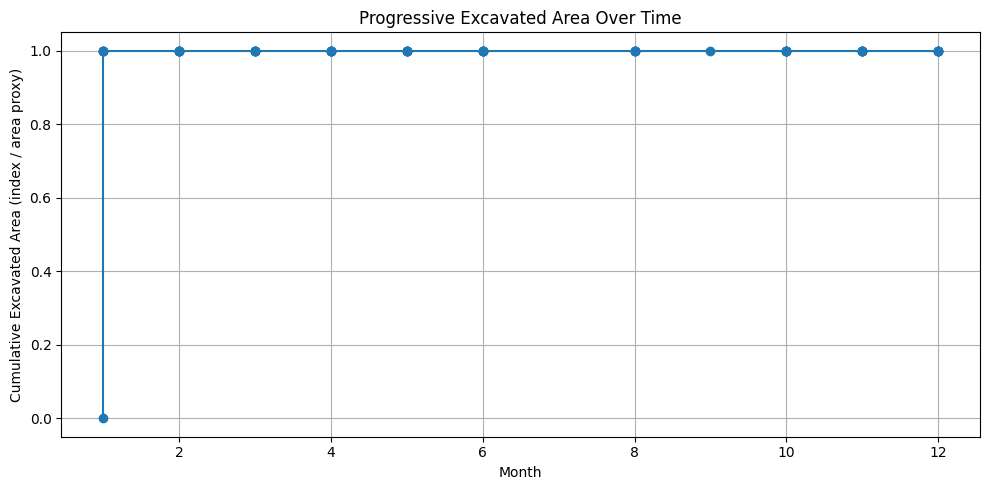

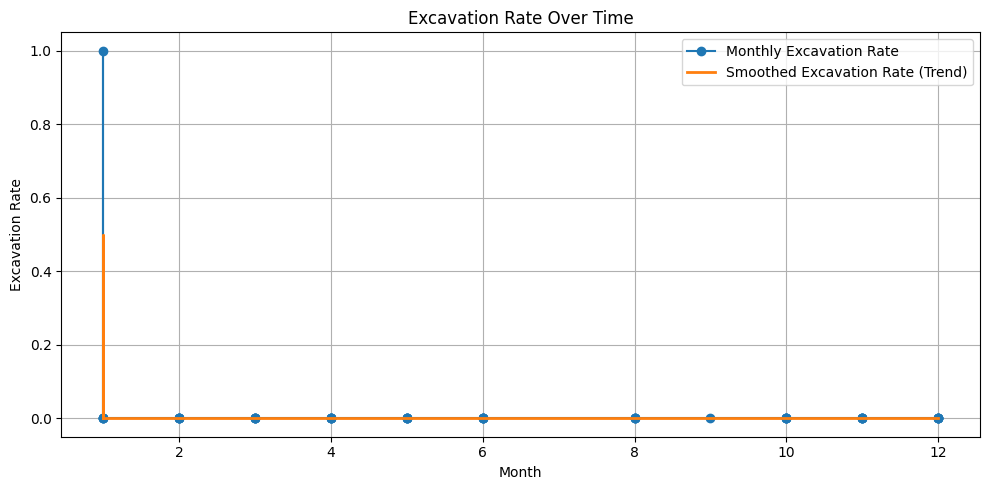

In [ ]:
import matplotlib.pyplot as plt

# -----------------------------
# Plot 1: Progressive Excavated Area
# -----------------------------
plt.figure(figsize=(10, 5))
plt.plot(
    final_df["month"],
    final_df["excav_area_progressive"],
    marker="o"
)
plt.xlabel("Month")
plt.ylabel("Cumulative Excavated Area (index / area proxy)")
plt.title("Progressive Excavated Area Over Time")
plt.grid(True)
plt.tight_layout()
plt.show()


# -----------------------------
# Plot 2: Excavation Rate (raw vs smoothed)
# -----------------------------
plt.figure(figsize=(10, 5))
plt.plot(
    final_df["month"],
    final_df["excav_rate"],
    marker="o",
    label="Monthly Excavation Rate"
)
plt.plot(
    final_df["month"],
    final_df["excav_rate_smooth"],
    linewidth=2,
    label="Smoothed Excavation Rate (Trend)"
)
plt.xlabel("Month")
plt.ylabel("Excavation Rate")
plt.title("Excavation Rate Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
shp_path = "/content/mines_cils.shp"

gdf = gpd.read_file(shp_path)
print("CRS:", gdf.crs)


CRS: EPSG:4326


In [ ]:
#Convert shapefile → Earth Engine
legal_mine = geemap.geopandas_to_ee(gdf)
aoi = legal_mine.geometry()

print("✅ AOI loaded into Earth Engine")


✅ AOI loaded into Earth Engine


In [ ]:
#Use AOI directly for Sentinel-2
s2 = (
    ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
    .filterBounds(aoi)
    .filterDate("2023-01-01", "2023-12-31")
    .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 20))
)


In [ ]:
mines_fc = geemap.geopandas_to_ee(gdf)
print("✅ mines_fc created")

✅ mines_fc created


In [ ]:
def add_utm_geom(feature):
    utm_geom = feature.geometry().transform("EPSG:32643", 10)
    return feature.setGeometry(utm_geom)

mines_utm = mines_fc.map(add_utm_geom)
print("✅ All mines converted to UTM (meters)")


✅ All mines converted to UTM (meters)


In [ ]:
def process_one_mine(mine_feature):

    aoi = mine_feature.geometry()

    # Load Sentinel-2
    s2 = (
        ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
        .filterBounds(aoi)
        .filterDate("2022-01-01", "2023-12-31")
        .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 20))
    )

    # Add indices
    def add_indices(img):
        ndvi = img.normalizedDifference(["B8", "B4"]).rename("NDVI")
        nbr  = img.normalizedDifference(["B8", "B12"]).rename("NBR")
        bsi = (
            img.select("B11").add(img.select("B4"))
            .subtract(img.select("B8").add(img.select("B2")))
            .divide(
                img.select("B11").add(img.select("B4"))
                .add(img.select("B8")).add(img.select("B2"))
            )
            .rename("BSI")
        )
        return img.addBands([ndvi, nbr, bsi])

    s2 = s2.map(add_indices)

    # Example: mean NDVI over time (summary feature)
    ndvi_mean = s2.select("NDVI").mean().reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=aoi,
        scale=10,
        maxPixels=1e9
    ).get("NDVI")

    return mine_feature.set("mean_ndvi", ndvi_mean)


In [ ]:
mine_fc = ee.FeatureCollection("content/sample_data/mine_fc")


In [ ]:
results_all_mines = mine_fc.map(process_one_mine)


In [ ]:
baseline = s2.select(["NDVI", "NBR", "BSI"]).median()


In [ ]:
def add_change(img):
    diff = img.select(["NDVI", "NBR", "BSI"]).subtract(baseline)
    mag = diff.pow(2).reduce("sum").sqrt().rename("change_mag")
    return img.addBands(mag)

s2 = s2.map(add_change)


In [ ]:
import ee
ee.Initialize(project='excavation-482417')

def process_one_mine(mine_feature):
    aoi = mine_feature.geometry()

    # 1) Load Sentinel-2 for this mine
    s2 = (
        ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
        .filterBounds(aoi)
        .filterDate("2023-01-01", "2023-12-31")
        .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 20))
    )

    # 2) Add NDVI, NBR, BSI
    def add_indices(img):
        ndvi = img.normalizedDifference(["B8", "B4"]).rename("NDVI")
        nbr  = img.normalizedDifference(["B8", "B12"]).rename("NBR")
        bsi = img.expression(
            "((B11 + B4) - (B8 + B2)) / ((B11 + B4) + (B8 + B2))",
            {
                "B11": img.select("B11"),
                "B4": img.select("B4"),
                "B8": img.select("B8"),
                "B2": img.select("B2")
            }
        ).rename("BSI")
        return img.addBands([ndvi, nbr, bsi])

    s2_idx = s2.map(add_indices)

    # 3) Optional baseline (not strictly needed for adaptiveness here)
    baseline = s2_idx.select(["NDVI", "NBR", "BSI"]).median()

    # 4) Adaptive excavation detection per image
    def add_excavation(img):
        # Feature stack for clustering
        diff = img.select(["NDVI", "NBR", "BSI"]).subtract(baseline)
        feats = img.select(["NDVI", "NBR", "BSI"]).addBands(
            diff.rename(["dNDVI", "dNBR", "dBSI"])
        )

        # Sample pixels inside the mine
        sample = feats.sample(
            region=aoi,
            scale=10,
            numPixels=5000,
            seed=0,
            geometries=False
        )

        # Train unsupervised KMeans with 2 clusters
        clusterer = ee.Clusterer.wekaKMeans(2).train(
            features=sample,
            inputProperties=["NDVI", "NBR", "BSI", "dNDVI", "dNBR", "dBSI"]
        )

        # Apply clustering to full image
        clustered = feats.cluster(clusterer).rename('cluster')

        # Compute mean BSI for cluster 0
        mean_bsi_0 = img.select('BSI').updateMask(clustered.eq(0)).reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=aoi,
            scale=10,
            maxPixels=1e9
        ).get('BSI')

        # Compute mean BSI for cluster 1
        mean_bsi_1 = img.select('BSI').updateMask(clustered.eq(1)).reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=aoi,
            scale=10,
            maxPixels=1e9
        ).get('BSI')

        mean_bsi_0 = ee.Number(mean_bsi_0)
        mean_bsi_1 = ee.Number(mean_bsi_1)

        # Excavated cluster = one with higher mean BSI (more bare soil)
        excavation_cluster = mean_bsi_1.gt(mean_bsi_0).int()  # 1 if cluster1>cluster0 else 0

        excavation = clustered.eq(excavation_cluster).selfMask().rename('excavation')
        return img.addBands(excavation)

    s2_excav = s2_idx.map(add_excavation)

    # 5) Example: excavated area per date inside legal mine
    def exc_area(img):
        area_img = img.select('excavation').multiply(ee.Image.pixelArea())
        stats = area_img.reduceRegion(
            reducer=ee.Reducer.sum(),
            geometry=aoi,
            scale=10,
            maxPixels=1e9
        )
        return ee.Feature(None, {
            'date': img.date().format('YYYY-MM-dd'),
            'excavation_ha': ee.Number(stats.get('excavation')).divide(10000)
        })

    exc_ts = ee.FeatureCollection(s2_excav.map(exc_area))
    total_excav = exc_ts.aggregate_sum('excavation_ha')

    return mine_feature.set({
        'total_excavation_ha': total_excav,
        'excavation_ts': exc_ts
    })

# Apply to all mines
results_all_mines = mine_fc.map(process_one_mine)


In [ ]:
# Example: take the first mine
one_mine = ee.Feature(mines_fc.first())
aoi = one_mine.geometry()

# Re-use the same S2 + indices + excavation steps, but outside map over mines
s2 = (
    ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
    .filterBounds(aoi)
    .filterDate("2022-01-01", "2023-12-31")
    .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 20))
)

def add_indices(img):
    ndvi = img.normalizedDifference(["B8", "B4"]).rename("NDVI")
    nbr  = img.normalizedDifference(["B8", "B12"]).rename("NBR")
    bsi = img.expression(
        "((B11 + B4) - (B8 + B2)) / ((B11 + B4) + (B8 + B2))",
        {
            "B11": img.select("B11"),
            "B4": img.select("B4"),
            "B8": img.select("B8"),
            "B2": img.select("B2")
        }
    ).rename("BSI")
    return img.addBands([ndvi, nbr, bsi])

s2_idx = s2.map(add_indices)
baseline = s2_idx.select(["NDVI", "NBR", "BSI"]).median()

def add_excavation(img):
    diff = img.select(["NDVI", "NBR", "BSI"]).subtract(baseline)
    feats = img.select(["NDVI", "NBR", "BSI"]).addBands(
        diff.rename(["dNDVI", "dNBR", "dBSI"])
    )

    sample = feats.sample(
        region=aoi,
        scale=10,
        numPixels=5000,
        seed=0,
        geometries=False
    )

    clusterer = ee.Clusterer.wekaKMeans(2).train(
        features=sample,
        inputProperties=["NDVI", "NBR", "BSI", "dNDVI", "dNBR", "dBSI"]
    )

    clustered = feats.cluster(clusterer).rename('cluster')

    mean_bsi_0 = img.select('BSI').updateMask(clustered.eq(0)).reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=aoi,
        scale=10,
        maxPixels=1e9
    ).get('BSI')

    mean_bsi_1 = img.select('BSI').updateMask(clustered.eq(1)).reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=aoi,
        scale=10,
        maxPixels=1e9
    ).get('BSI')

    mean_bsi_0 = ee.Number(mean_bsi_0)
    mean_bsi_1 = ee.Number(mean_bsi_1)
    excavation_cluster = mean_bsi_1.gt(mean_bsi_0).int()

    excavation = clustered.eq(excavation_cluster).selfMask().rename('excavation')
    return img.addBands(excavation)

s2_excav = s2_idx.map(add_excavation)

def exc_area(img):
    area_img = img.select('excavation').multiply(ee.Image.pixelArea())
    stats = area_img.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=aoi,
        scale=10,
        maxPixels=1e9
    )
    return ee.Feature(
        None,
        {
            'date': img.date().format('YYYY-MM-dd'),
            'excavation_m2': ee.Number(stats.get('excavation')),
        }
    )

exc_ts = ee.FeatureCollection(s2_excav.map(exc_area))


In [ ]:
exc_dates = exc_ts.aggregate_array('date').getInfo()
exc_areas = exc_ts.aggregate_array('excavation_m2').getInfo()

import datetime
records = []
for d, a in zip(exc_dates, exc_areas):
    if a is None:
        continue
    dt = datetime.datetime.strptime(d, '%Y-%m-%d')
    records.append((dt, a))

records.sort(key=lambda x: x[0])
dates_sorted = [r[0] for r in records]
areas_sorted = [r[1] for r in records]

rates = []
rate_dates = []
for i in range(1, len(dates_sorted)):
    dt_prev = dates_sorted[i - 1]
    dt_curr = dates_sorted[i]
    area_prev = areas_sorted[i - 1]
    area_curr = areas_sorted[i]

    delta_days = (dt_curr - dt_prev).days
    if delta_days == 0:
        delta_days = 1

    dA = area_curr - area_prev
    rate = dA / delta_days

    rates.append(rate)
    rate_dates.append(dt_curr)

# Convert to ha and strings for plotting
areas_ha = [a / 10000.0 for a in areas_sorted]
rates_ha_per_day = [r / 10000.0 for r in rates]
date_strs = [d.strftime('%Y-%m-%d') for d in dates_sorted]
rate_date_strs = [d.strftime('%Y-%m-%d') for d in rate_dates]


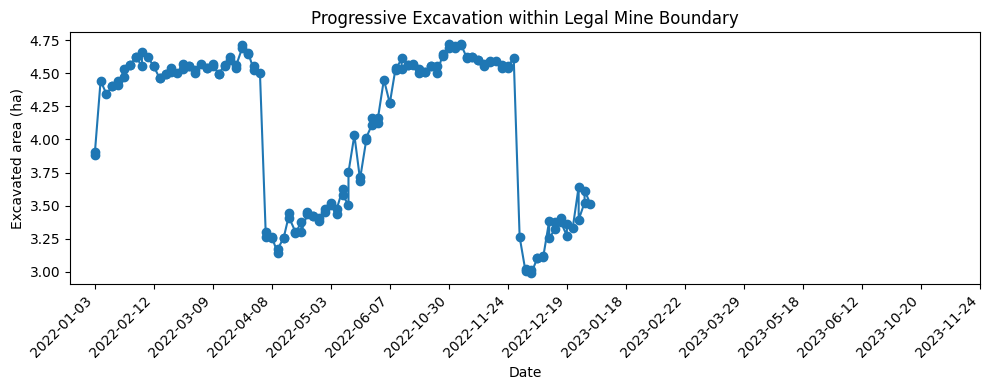

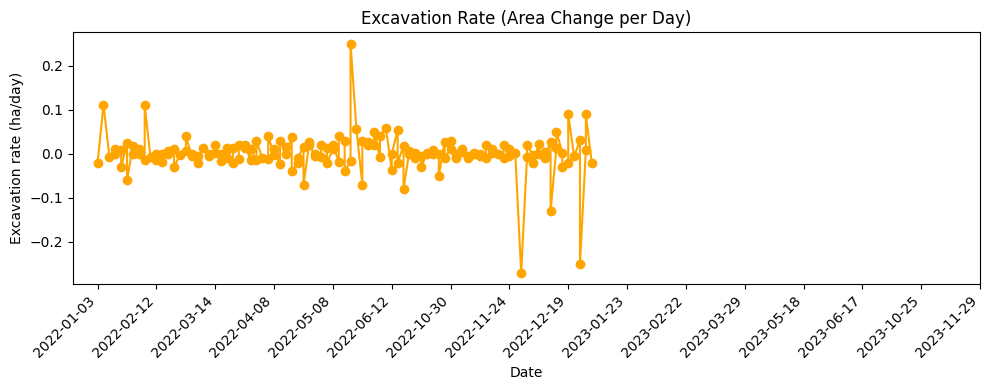

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------------
# 1) Progressive excavated area curve
# -----------------------------------
plt.figure(figsize=(10, 4))
plt.plot(date_strs, areas_ha, marker='o')
plt.ylabel('Excavated area (ha)')
plt.xlabel('Date')
plt.title('Progressive Excavation within Legal Mine Boundary')

# Show only every 10th date label
idx = np.arange(len(date_strs))
step = 10  # change to 7 or 15 if you want more/less labels
plt.xticks(
    idx[::step],
    [date_strs[i] for i in idx[::step]],
    rotation=45,
    ha='right'
)

plt.tight_layout()
plt.show()

# -----------------------------------
# 2) Excavation rate curve
# -----------------------------------
plt.figure(figsize=(10, 4))
plt.plot(rate_date_strs, rates_ha_per_day, marker='o', color='orange')
plt.ylabel('Excavation rate (ha/day)')
plt.xlabel('Date')
plt.title('Excavation Rate (Area Change per Day)')

idx2 = np.arange(len(rate_date_strs))
plt.xticks(
    idx2[::step],
    [rate_date_strs[i] for i in idx2[::step]],
    rotation=45,
    ha='right'
)

plt.tight_layout()
plt.show()


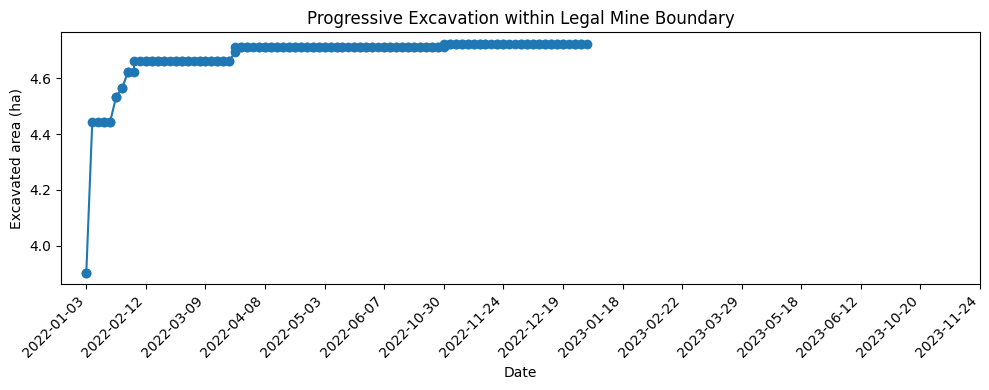

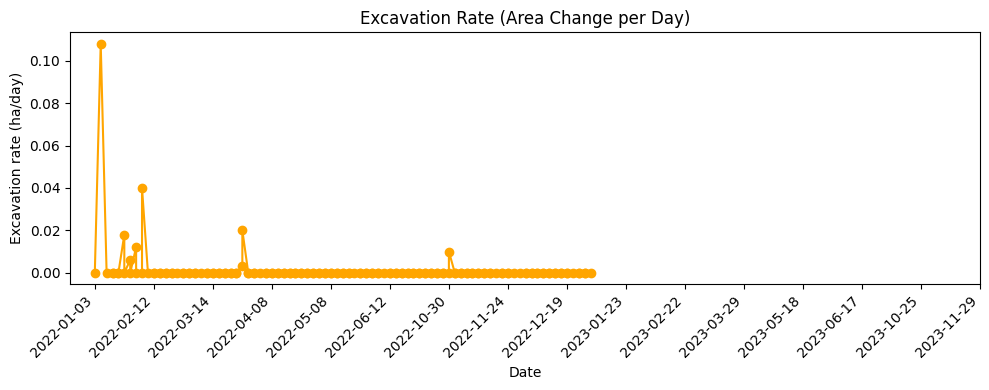

In [ ]:
import datetime
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------------
# 1) Make excavation area cumulative
# -----------------------------------
areas_cum = []
max_so_far = 0.0

for a in areas_sorted:
    if a is None:
        a = 0.0
    max_so_far = max(max_so_far, a)   # running maximum
    areas_cum.append(max_so_far)

# Convert to ha
areas_ha = [a / 10000.0 for a in areas_cum]
date_strs = [d.strftime('%Y-%m-%d') for d in dates_sorted]

# -----------------------------------
# 2) Recompute rate from cumulative area
# -----------------------------------
rates = []
rate_dates = []

for i in range(1, len(dates_sorted)):
    dt_prev = dates_sorted[i - 1]
    dt_curr = dates_sorted[i]
    area_prev = areas_cum[i - 1]
    area_curr = areas_cum[i]

    delta_days = (dt_curr - dt_prev).days or 1
    dA = area_curr - area_prev          # m²
    rate = dA / delta_days             # m²/day
    rates.append(rate)
    rate_dates.append(dt_curr)

rates_ha_per_day = [r / 10000.0 for r in rates]
rate_date_strs = [d.strftime('%Y-%m-%d') for d in rate_dates]

# -----------------------------------
# 3) Plot with cleaner x-axis
# -----------------------------------
step = 10  # show every 10th label

plt.figure(figsize=(10, 4))
plt.plot(date_strs, areas_ha, marker='o')
plt.ylabel('Excavated area (ha)')
plt.xlabel('Date')
plt.title('Progressive Excavation within Legal Mine Boundary')

idx = np.arange(len(date_strs))
plt.xticks(idx[::step], [date_strs[i] for i in idx[::step]],
           rotation=45, ha='right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(rate_date_strs, rates_ha_per_day, marker='o', color='orange')
plt.ylabel('Excavation rate (ha/day)')
plt.xlabel('Date')
plt.title('Excavation Rate (Area Change per Day)')

idx2 = np.arange(len(rate_date_strs))
plt.xticks(idx2[::step], [rate_date_strs[i] for i in idx2[::step]],
           rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
import geopandas as gpd
import ee

# Load shapefile from wherever it actually is
gdf = gpd.read_file("mines_cils.shp")   # adjust full path if needed

# Pick one mine
row = gdf.iloc[0]

# Build EE geometry
mine_geom = ee.Geometry.Polygon(row.geometry.__geo_interface__['coordinates'])


In [ ]:
import ee
import datetime

# ------------- NO-GO ZONES -------------
centroid = mine_geom.centroid()

# First synthetic no-go zone
no_go_1 = centroid.buffer(300)

# Second synthetic no-go zone (offset ring)
outer = centroid.buffer(600)
inner = centroid.buffer(400)
no_go_2 = outer.difference(inner)

no_go_fc = ee.FeatureCollection([
    ee.Feature(no_go_1, {'type': 'forest'}),
    ee.Feature(no_go_2, {'type': 'habitation'})
])

no_go_geom = no_go_fc.geometry()

# ------------- SENTINEL-2 + NBR -------------
s2 = (ee.ImageCollection("COPERNICUS/S2_SR")
      .filterBounds(mine_geom)
      .filterDate('2022-01-01', '2023-12-31')
      .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)))

def add_nbr(img):
    nbr = img.normalizedDifference(['B8', 'B12']).rename('NBR')
    return img.addBands(nbr)

s2 = s2.map(add_nbr)

def excavation_mask(img):
    excavated = img.select('NBR').lt(0.1).rename('excavation')
    return excavated.set('date', img.date().format('YYYY-MM-dd'))

excavation_ts = s2.map(excavation_mask)

# ------------- VIOLATION AREA IN NO-GO ZONE -------------
def detect_violation(img):
    violation = img.clip(no_go_geom)

    area = (violation
            .multiply(ee.Image.pixelArea())
            .reduceRegion(
                reducer=ee.Reducer.sum(),
                geometry=no_go_geom,
                scale=10,
                maxPixels=1e13
            )
            .get('excavation'))

    return ee.Feature(None, {
        'date': img.get('date'),
        'no_go_excavation_m2': area
    })

violation_ts = ee.FeatureCollection(excavation_ts.map(detect_violation))


In [ ]:
dates = violation_ts.aggregate_array('date').getInfo()
areas = violation_ts.aggregate_array('no_go_excavation_m2').getInfo()

records = []
for d, a in zip(dates, areas):
    if a is None:
        continue
    records.append((datetime.datetime.strptime(d, '%Y-%m-%d'), a))

records.sort(key=lambda x: x[0])

prev_area = 0
print("\nNO-GO ZONE VIOLATION MONITORING\n")

for dt, area in records:
    area_ha = area / 10000.0
    print(f"{dt.date()} → {area_ha:.3f} ha")

    if area > prev_area and area > 0:
        print("ALERT: Excavation detected/expanded in NO-GO ZONE")

    prev_area = area



NO-GO ZONE VIOLATION MONITORING

2022-01-03 → 3.288 ha
ALERT: Excavation detected/expanded in NO-GO ZONE
2022-01-03 → 3.529 ha
ALERT: Excavation detected/expanded in NO-GO ZONE
2022-01-08 → 0.952 ha
2022-01-23 → 4.036 ha
ALERT: Excavation detected/expanded in NO-GO ZONE
2022-01-28 → 7.260 ha
ALERT: Excavation detected/expanded in NO-GO ZONE
2022-01-28 → 7.388 ha
ALERT: Excavation detected/expanded in NO-GO ZONE
2022-02-02 → 8.756 ha
ALERT: Excavation detected/expanded in NO-GO ZONE
2022-02-02 → 8.918 ha
ALERT: Excavation detected/expanded in NO-GO ZONE
2022-02-07 → 8.293 ha
2022-02-07 → 8.336 ha
ALERT: Excavation detected/expanded in NO-GO ZONE
2022-02-12 → 10.083 ha
ALERT: Excavation detected/expanded in NO-GO ZONE
2022-02-12 → 10.121 ha
ALERT: Excavation detected/expanded in NO-GO ZONE
2022-02-17 → 10.889 ha
ALERT: Excavation detected/expanded in NO-GO ZONE
2022-02-17 → 10.838 ha
2022-02-22 → 13.917 ha
ALERT: Excavation detected/expanded in NO-GO ZONE
2022-02-22 → 13.957 ha
ALERT: E

In [ ]:
import os
print(os.listdir('/content'))

['.config', 'mines_cils.shx', 'mines_cils.sbn', 'mines_cils.cpg', 'mines_cils.sbx', 'mines_cils.shp.xml', 'mines_cils.shp', 'mines_cils.dbf', 'mines_cils.prj', 'sample_data']


In [ ]:
geom = mines_gdf.geometry.iloc[0]

print(geom.geom_type)  # e.g., 'Point', 'Polygon', 'MultiPolygon'

Polygon


In [ ]:
coords = list(geom.exterior.coords)
mine_geom = ee.Geometry.Polygon([coords])

In [ ]:
import ee
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import geopandas as gpd

# Initialize Earth Engine
ee.Initialize(project='excavation-482417')

# Load your mines shapefile
mines_gdf = gpd.read_file('/content/mines_cils.shp')
print(f"Number of mines: {len(mines_gdf)}")

# Example: select first mine (Polygon conversion)
geom = mines_gdf.geometry.iloc[0]
mine_geom = ee.Geometry(geom.__geo_interface__)   # safer conversion

# Load Sentinel-2 collection and filter by date and location
collection = (ee.ImageCollection('COPERNICUS/S2_SR')
              .filterBounds(mine_geom)
              .filterDate('2023-01-01', '2023-12-31')
              .select(['B2','B3','B4','B8']))

# Function to convert EE image collection to time-series (mean over polygon)
def extract_pixel_time_series(image_collection, geometry):
    images = image_collection.toList(image_collection.size())
    band_names = image_collection.first().bandNames().getInfo()

    data = []
    for i in range(image_collection.size().getInfo()):
        img = ee.Image(images.get(i))
        stats = img.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=geometry,
            scale=10,
            bestEffort=True
        ).getInfo()
        data.append([stats.get(b) for b in band_names])

    return np.array(data)  # shape: (time, bands)

# Extract time-series for the mine
pixel_ts = extract_pixel_time_series(collection, mine_geom)  # shape: (time, bands)

# Reshape for clustering: samples x features
n_time, n_bands = pixel_ts.shape
pixel_ts_reshaped = pixel_ts.reshape(n_time, n_bands)

# Apply KMeans clustering (unsupervised)
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(pixel_ts_reshaped)

print("Cluster labels for time steps:", labels)

Number of mines: 506
Cluster labels for time steps: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 1 1
 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 0 0 1 1 1 1 0 0 0 0 1
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
n_pixels = pixel_ts_reshaped.shape[0]
print("Number of pixels:", n_pixels)


Number of pixels: 146


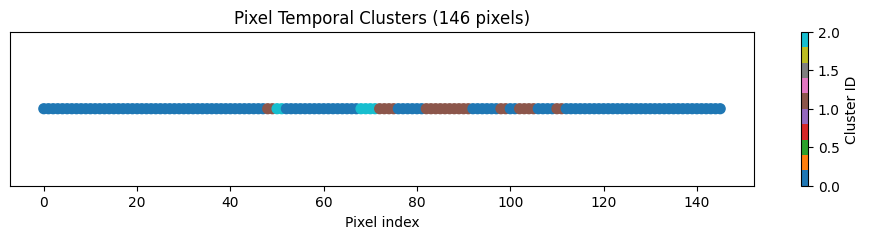

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# labels: your cluster labels (size = 146)
# Let's create dummy coordinates for plotting
# Ideally, these come from your pixel extraction (e.g., ee.Geometry.centroid or grid)
# For demonstration, we just place them along a line
coords = np.arange(146).reshape(-1, 1)  # x-coordinate
y_coords = np.zeros(146)  # y-coordinate

# Scatter plot showing clusters
plt.figure(figsize=(12, 2))
plt.scatter(coords, y_coords, c=labels, cmap='tab10', s=50)
plt.colorbar(label='Cluster ID')
plt.title("Pixel Temporal Clusters (146 pixels)")
plt.xlabel("Pixel index")
plt.yticks([])
plt.show()


In [ ]:
import ee
import geopandas as gpd
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

# --------------------------------------------------
# 1. Load first mine polygon
# --------------------------------------------------
mines = gpd.read_file("/content/mines_cils.shp")
from shapely.geometry import mapping

shapely_geom = mines.iloc[0].geometry
geojson = mapping(shapely_geom)

mine_geom = ee.Geometry(geojson)

print("Using first mine polygon")


# --------------------------------------------------
# 2. Sentinel-2 preprocessing
# --------------------------------------------------
def mask_clouds(img):
    scl = img.select('SCL')
    # Keep: vegetation, bare soil, built-up, water
    mask = scl.eq(4).Or(scl.eq(5)) \
        .Or(scl.eq(6)).Or(scl.eq(7))
    return img.updateMask(mask)

def add_ndvi(img):
    return img.addBands(
        img.normalizedDifference(['B8', 'B4']).rename('NDVI')
    )

collection = (
    ee.ImageCollection("COPERNICUS/S2_SR")
    .filterBounds(mine_geom)
    .filterDate("2023-01-01", "2023-12-31")
    .map(mask_clouds)
    .map(add_ndvi)
    .select("NDVI")
)

# Monthly median
def monthly_img(m):
    start = ee.Date.fromYMD(2023, m, 1)
    end = start.advance(1, 'month')
    return collection.filterDate(start, end).median().set("month", m)

monthly = ee.ImageCollection(
    ee.List.sequence(1, 12).map(monthly_img)
)

# --------------------------------------------------
# 3. FIXED PIXEL SAMPLING (key fix)
# --------------------------------------------------
# Sample pixels ONCE (reference grid)
sample = monthly.first().sample(
    region=mine_geom,
    scale=10,
    geometries=False
)

pixel_ids = sample.aggregate_array('.geo').getInfo()
n_pixels = len(pixel_ids)

# Extract NDVI per month for same pixels
time_series = []

for m in range(1, 13):
    img = monthly.filter(ee.Filter.eq("month", m)).first()
    values = img.sample(
        region=mine_geom,
        scale=10,
        geometries=False
    ).aggregate_array("NDVI").getInfo()

    # Pad missing values
    if values is None:
        values = [np.nan] * n_pixels
    elif len(values) < n_pixels:
        values += [np.nan] * (n_pixels - len(values))

    time_series.append(values)

# pixels × time
X = np.array(time_series).T
print("Total pixels:", X.shape[0])

# Fill missing values (cloud gaps)
X = np.nan_to_num(X, nan=np.nanmedian(X))

# --------------------------------------------------
# 4. UNSUPERVISED LEARNING BLOCK
# --------------------------------------------------
kmeans = KMeans(n_clusters=3, random_state=42)
pixel_clusters = kmeans.fit_predict(X)

# --------------------------------------------------
# 5. NO-GO ZONE + AREA TIME SERIES
# --------------------------------------------------
centroid = mine_geom.centroid()
no_go = centroid.buffer(300)

def disturbed_area(img):
    disturbed = img.lt(0.2)
    area = disturbed.multiply(ee.Image.pixelArea()) \
        .reduceRegion(
            ee.Reducer.sum(),
            no_go,
            scale=10,
            bestEffort=True
        ).get("NDVI")
    return ee.Feature(None, {
        "month": img.get("month"),
        "area": area
    })

area_fc = monthly.map(disturbed_area).getInfo()["features"]

area_ts = pd.DataFrame([
    {
        "month": f["properties"]["month"],
        "area_m2": f["properties"]["area"] if f["properties"]["area"] is not None else 0
    }
    for f in area_fc
]).sort_values("month")

# --------------------------------------------------
# 6. SIMPLE ALERT RULE
# --------------------------------------------------
alerts = []
prev = 0
detected = False

for _, r in area_ts.iterrows():
    if not detected and r.area_m2 > 500:
        alerts.append(f"⚠️ First excavation detected (month {int(r.month)})")
        detected = True
    if r.area_m2 - prev > 200:
        alerts.append(f"🚨 Rapid growth (month {int(r.month)})")
    prev = r.area_m2

# --------------------------------------------------
# 7. OUTPUT
# --------------------------------------------------
print("\nCluster labels (first 20 pixels):", pixel_clusters[:20])
print("\nArea time series:")
print(area_ts)

print("\nAlerts:")
for a in alerts:
    print(a)


Using first mine polygon
Total pixels: 846

Cluster labels (first 20 pixels): [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]

Area time series:
    month       area_m2
0       1  35637.431313
1       2  41622.362465
2       3  60403.376897
3       4  57737.717922
4       5  52691.348990
5       6  53442.396040
6       7  24665.075508
7       8  24030.301590
8       9  11607.074142
9      10  24755.748581
10     11  27929.570503
11     12  30287.265259

Alerts:
⚠️ First excavation detected (month 1)
🚨 Rapid growth (month 1)
🚨 Rapid growth (month 2)
🚨 Rapid growth (month 3)
🚨 Rapid growth (month 6)
🚨 Rapid growth (month 10)
🚨 Rapid growth (month 11)
🚨 Rapid growth (month 12)


In [ ]:
# 1️⃣ Install required packages
!pip install streamlit pyngrok streamlit-folium folium geopandas scikit-learn earthengine-api


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 62.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 523.7/523.7 kB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 110.4 MB/s eta 0:00:00


In [ ]:
with open("dashboard.py", "w") as f:
    f.write("""# dashboard.py

import streamlit as st
import geopandas as gpd
import pandas as pd
import numpy as np
import folium
from streamlit_folium import st_folium
from shapely.geometry import mapping
import ee
from sklearn.cluster import KMeans

# ------------------------------
# Initialize Earth Engine
# ------------------------------
ee.Initialize()

# ------------------------------
# Load mines shapefile
# ------------------------------
mines = gpd.read_file("mines_cils.shp")  # path to your shapefile

# Sidebar: Mine selection
mine_names = mines.index.tolist()
selected_index = st.sidebar.selectbox("Select Mine", mine_names)
selected_mine = mines.iloc[selected_index]
mine_geom = ee.Geometry(mapping(selected_mine.geometry))

st.title("Mine Monitoring Dashboard")
st.subheader(f"Selected Mine: {selected_index}")

# ------------------------------
# Sentinel-2 Preprocessing
# ------------------------------
def mask_clouds(img):
    scl = img.select('SCL')
    mask = scl.eq(4).Or(scl.eq(5)).Or(scl.eq(6)).Or(scl.eq(7))
    return img.updateMask(mask)

def add_ndvi(img):
    return img.addBands(img.normalizedDifference(['B8','B4']).rename('NDVI'))

collection = (
    ee.ImageCollection("COPERNICUS/S2_SR")
    .filterBounds(mine_geom)
    .filterDate("2023-01-01", "2023-3-31")
    .map(mask_clouds)
    .map(add_ndvi)
    .select("NDVI")
)

# Monthly median
def monthly_img(m):
    start = ee.Date.fromYMD(2023, m, 1)
    end = start.advance(1, 'month')
    return collection.filterDate(start, end).median().set("month", m)

monthly = ee.ImageCollection(
    ee.List.sequence(1,12).map(monthly_img)
)

# ------------------------------
# Sample pixels & build time series
# ------------------------------
sample = monthly.first().sample(region=mine_geom, scale=30, geometries=False)
n_pixels = len(sample.aggregate_array('.geo').getInfo())

time_series = []
for m in range(1,4):
    img = monthly.filter(ee.Filter.eq("month", m)).first()
    values = img.sample(region=mine_geom, scale=30, geometries=False).limit(50).aggregate_array("NDVI").getInfo()
    if values is None:
        values = [np.nan]*n_pixels
    elif len(values) < n_pixels:
        values += [np.nan]*(n_pixels - len(values))
    time_series.append(values)

X = np.array(time_series).T
X = np.nan_to_num(X, nan=np.nanmedian(X))

# ------------------------------
# Unsupervised Clustering
# ------------------------------
kmeans = KMeans(n_clusters=3, random_state=42)
pixel_clusters = kmeans.fit_predict(X)

st.subheader("Pixel Clusters (first 20 pixels)")
st.write(pixel_clusters[:20])

# ------------------------------
# Disturbed area + alerts
# ------------------------------
centroid = mine_geom.centroid()
no_go = centroid.buffer(300)

def disturbed_area(img):
    disturbed = img.lt(0.2)
    area = disturbed.multiply(ee.Image.pixelArea()).reduceRegion(
        ee.Reducer.sum(), no_go, scale=10, bestEffort=True
    ).get("NDVI")
    return ee.Feature(None, {"month": img.get("month"), "area": area})

area_fc = monthly.map(disturbed_area).getInfo()["features"]
area_ts = pd.DataFrame([
    {"month": f["properties"]["month"],
     "area_m2": f["properties"]["area"] if f["properties"]["area"] is not None else 0}
    for f in area_fc
]).sort_values("month")

st.subheader("Excavation Area Time Series")
st.line_chart(area_ts.set_index("month")["area_m2"])

# Alerts
alerts = []
prev = 0
detected = False
for _, r in area_ts.iterrows():
    if not detected and r.area_m2 > 500:
        alerts.append(f"⚠️ First excavation detected (month {int(r.month)})")
        detected = True
    if r.area_m2 - prev > 200:
        alerts.append(f"🚨 Rapid growth (month {int(r.month)})")
    prev = r.area_m2

st.subheader("Alerts")
for a in alerts:
    st.warning(a)

# ------------------------------
# Map Visualization
# ------------------------------
m = folium.Map(location=[selected_mine.geometry.centroid.y, selected_mine.geometry.centroid.x], zoom_start=14)
folium.GeoJson(mapping(selected_mine.geometry), style_function=lambda x: {'fillColor':'yellow','color':'red','weight':2}).add_to(m)
st.subheader("Mine Map")
st_folium(m, width=700, height=500)
""")


In [ ]:
from google.colab import files
files.download("dashboard.py")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import geopandas as gpd

gdf = gpd.read_file("/content/mines_cils.shp")

# Print all column names
print(gdf.columns)


Index(['area', 'perimeter', 'geometry'], dtype='object')
